In [1]:
from MS2LDA.motif_parser import load_m2m_folder
from MS2LDA.Add_On.MassQL.MassQL4MotifDB import load_motifDB, motifDB2motifs
from MS2LDA.utils import retrieve_spec4doc

from MS2LDA.Add_On.Fingerprints.FP_annotation import annotate_motifs as calc_fingerprints

import pickle
import tomotopy as tp
from rdkit.Chem import MACCSkeys

In [2]:
from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolFromSmarts


from typing import Dict, List, Optional
from rdkit.Chem import MolFromSmiles, rdFMCS, RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm


from rdkit.Chem import RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import MolFromSmarts


from typing import Dict, List, Optional
from rdkit.Chem import MolFromSmiles, rdFMCS, RDKFingerprint
from rdkit.DataStructs import TanimotoSimilarity
import numpy as np
from tqdm import tqdm

In [3]:
motifDB_1, motifDB_2 = load_motifDB("./CaseStudy_Corinna_Library_filtered_1000motifs_output_100625/motifset_optimized.json")
motifs = motifDB2motifs(motifDB_2)
with open('./CaseStudy_Corinna_Library_filtered_1000motifs_output_100625/doc2spec_map.pkl', 'rb') as f:
    doc2spec_map = pickle.load(f)
lda_model = tp.LDAModel.load('./CaseStudy_Corinna_Library_filtered_1000motifs_output_100625/ms2lda.bin')

In [4]:
len(motifs)

568

In [127]:
# Daylight fingerprint
def safe_mol(smiles: Optional[str]):
    try:
        return MolFromSmiles(smiles)
    except:
        print(smiles)
        return None


def compute_mcs_num_atoms(mols):
    if not mols:
        return 0, ""
    try:
        mcs = rdFMCS.FindMCS(
            mols,
            bondCompare=rdFMCS.BondCompare.CompareAny,
            completeRingsOnly=True,
            ringMatchesRingOnly=True,
            timeout=5,
        )
        return int(mcs.numAtoms), mcs.smartsString
    except:
        return 0, ""


def calculate_sos(smaller_fp, bigger_fp):
    """ substructure overlap score where first input is MAG and second associated molecule"""
    s = np.asarray(smaller_fp)
    b = np.asarray(bigger_fp)
    inter = np.sum(s & b)      
    denom = np.sum(s)
    return inter / denom if inter > 0 else 0.0


def process_motifs(motifs, lda_model, doc2spec_map, prob_threshold: float = 0.5, fp_type="rdkit", min_candidates=4, max_candidates=5) -> dict:
    motif_ids = []
    num_atoms = []
    len_frag_loss = []
    mcs_smarts = []
    inter_sims = []
    molecules_by_motif = {}

    for motif in tqdm(motifs):
        annotation = motif.get("auto_annotation", [])
        if len(annotation) <= 1:
            smarts = [s for s in annotation][0]
            mol = MolFromSmiles(smarts)
            n_atoms = mol.GetNumAtoms()

        else:
            ann_mols = [safe_mol(s) for s in annotation]
            ann_mols = [m for m in ann_mols if m is not None]
            n_atoms, smarts = compute_mcs_num_atoms(ann_mols)

        try:
            motif_id = int(motif.get("id").split("_")[1])
        except:
            continue

        motif_ids.append(motif_id)
        len_frag_loss.append(len(getattr(motif.peaks, "mz", [])))

        # MCS calculation
        #ann_mols = [safe_mol(s) for s in annotation]
        #ann_mols = [m for m in ann_mols if m is not None]
        #n_atoms, smarts = compute_mcs_num_atoms(ann_mols)
        num_atoms.append(n_atoms)
        mcs_smarts.append(smarts)

        # ---------- Compute motif representative fingerprint (Daylight) ----------
        rep_fp_ = calc_fingerprints([annotation], fp_type=fp_type, threshold=0.9)[0]
        
        # Create an empty ExplicitBitVect of the same length
        rep_fp = ExplicitBitVect(len(rep_fp_))
        
        # Set bits based on the numpy array
        for i, bit in enumerate(rep_fp_):
            if bit:
                rep_fp.SetBit(i)


        # ---------- Collect candidate molecules ----------
        candidate_mols = []
        for doc_id, doc in enumerate(lda_model.docs):
            for _motif_id, prob in doc.get_topics():
                if _motif_id == motif_id and prob >= prob_threshold:
                    spec = retrieve_spec4doc(doc2spec_map, lda_model, doc_id)
                    mol = safe_mol(spec.get("smiles"))
                    if mol is None:
                        print(spec.metadata)
                    if mol is not None:
                        candidate_mols.append(mol)

        molecules_by_motif[motif_id] = candidate_mols

        if rep_fp is None or not candidate_mols:
            if rep_fp is None:
                pass#print("no fp")
            else:
                pass#print("no candidate mols")
            inter_sims.append(np.nan)
        elif len(candidate_mols) >= min_candidates and len(candidate_mols) <= max_candidates:
            if fp_type == "maccs":
                fps = [MACCSkeys.GenMACCSKeys(m) for m in candidate_mols]
            elif fp_type == "rdkit":
                fps = [RDKFingerprint(m) for m in candidate_mols]

            # convert ExplicitBitVect → list of ints so calculate_sos can use sum() and zip()
            rep_fp_list = list(rep_fp)

            sims = []
            for fp in fps:
                fp_list = list(fp)
                sim = calculate_sos(rep_fp_list, fp_list)
                sims.append(sim)

            inter_sims.append(float(np.mean(sims)))
        else:
            inter_sims.append(np.nan)

    return {
        "motif_ids": motif_ids,
        "num_atoms": num_atoms,
        "len_frag_loss": len_frag_loss,
        "mcs_smarts": mcs_smarts,
        "molecules_by_motif": molecules_by_motif,
        "inter_sims": inter_sims
    }


In [150]:
results_1 = process_motifs(motifs, lda_model, doc2spec_map, fp_type="rdkit", min_candidates=0, max_candidates=1)

  0%|▏                                                                                 | 1/568 [00:01<15:09,  1.60s/it]

no candidate mols


  1%|▊                                                                                 | 6/568 [00:09<14:36,  1.56s/it]

no candidate mols


  3%|██▋                                                                              | 19/568 [00:30<15:46,  1.72s/it]

no candidate mols


  4%|███▏                                                                             | 22/568 [00:35<15:27,  1.70s/it]

no candidate mols


  4%|███▌                                                                             | 25/568 [00:40<15:09,  1.68s/it]

no candidate mols


  5%|████▎                                                                            | 30/568 [00:49<15:16,  1.70s/it]

no candidate mols


 11%|█████████▏                                                                       | 64/568 [01:54<14:19,  1.71s/it]

no candidate mols


 12%|█████████▉                                                                       | 70/568 [02:04<14:03,  1.69s/it]

no candidate mols


 12%|██████████▏                                                                      | 71/568 [02:06<14:07,  1.70s/it]

no candidate mols


 13%|██████████▌                                                                      | 74/568 [02:16<22:38,  2.75s/it]

no candidate mols


 14%|███████████▌                                                                     | 81/568 [02:28<14:39,  1.81s/it]

no candidate mols


 15%|████████████                                                                     | 85/568 [02:35<13:43,  1.70s/it]

no candidate mols


 16%|█████████████▎                                                                   | 93/568 [02:48<13:05,  1.65s/it]

no candidate mols


 17%|█████████████▋                                                                   | 96/568 [02:53<13:19,  1.69s/it]

no candidate mols


 17%|██████████████                                                                   | 99/568 [02:58<13:16,  1.70s/it]

no candidate mols


 18%|██████████████▌                                                                 | 103/568 [03:07<17:01,  2.20s/it]

no candidate mols


 19%|███████████████                                                                 | 107/568 [03:14<13:48,  1.80s/it]

no candidate mols


 20%|████████████████▏                                                               | 115/568 [03:28<12:33,  1.66s/it]

no candidate mols


 20%|████████████████▎                                                               | 116/568 [03:29<12:26,  1.65s/it]

no candidate mols


 23%|██████████████████▍                                                             | 131/568 [03:55<12:41,  1.74s/it]

no candidate mols


 23%|██████████████████▋                                                             | 133/568 [03:58<12:26,  1.72s/it]

no candidate mols


 24%|███████████████████                                                             | 135/568 [04:07<20:03,  2.78s/it]

no candidate mols


 24%|███████████████████▏                                                            | 136/568 [04:08<17:31,  2.43s/it]

no candidate mols


 25%|███████████████████▋                                                            | 140/568 [04:15<13:24,  1.88s/it]

no candidate mols


 27%|█████████████████████▋                                                          | 154/568 [04:39<11:36,  1.68s/it]

no candidate mols


 27%|█████████████████████▉                                                          | 156/568 [04:43<11:39,  1.70s/it]

no candidate mols


 31%|████████████████████████▋                                                       | 175/568 [05:15<10:58,  1.68s/it]

no candidate mols


 32%|█████████████████████████▎                                                      | 180/568 [05:23<10:50,  1.68s/it]

no candidate mols


 32%|█████████████████████████▊                                                      | 183/568 [05:28<10:48,  1.69s/it]

no candidate mols


 33%|██████████████████████████                                                      | 185/568 [05:32<11:01,  1.73s/it]

no candidate mols


 33%|██████████████████████████▍                                                     | 188/568 [05:37<10:54,  1.72s/it]

no candidate mols


 34%|██████████████████████████▉                                                     | 191/568 [05:42<10:47,  1.72s/it]

no candidate mols


 34%|███████████████████████████                                                     | 192/568 [05:44<10:32,  1.68s/it]

no candidate mols


 34%|███████████████████████████▏                                                    | 193/568 [05:46<10:27,  1.67s/it]

no candidate mols


 36%|████████████████████████████▍                                                   | 202/568 [06:01<10:26,  1.71s/it]

no candidate mols


 36%|████████████████████████████▌                                                   | 203/568 [06:02<10:21,  1.70s/it]

no candidate mols


 36%|█████████████████████████████▏                                                  | 207/568 [06:09<10:13,  1.70s/it]

no candidate mols


 37%|█████████████████████████████▍                                                  | 209/568 [06:13<10:07,  1.69s/it]

no candidate mols


 37%|█████████████████████████████▋                                                  | 211/568 [06:16<10:03,  1.69s/it]

no candidate mols


 38%|██████████████████████████████▎                                                 | 215/568 [06:23<09:55,  1.69s/it]

no candidate mols


 39%|██████████████████████████████▉                                                 | 220/568 [06:31<09:41,  1.67s/it]

no candidate mols


 39%|███████████████████████████████▏                                                | 221/568 [06:33<09:38,  1.67s/it]

no candidate mols


 39%|███████████████████████████████▎                                                | 222/568 [06:34<09:33,  1.66s/it]

no candidate mols


 42%|█████████████████████████████████▊                                              | 240/568 [07:05<09:14,  1.69s/it]

no candidate mols


 43%|██████████████████████████████████▏                                             | 243/568 [07:10<09:01,  1.67s/it]

no candidate mols


 44%|███████████████████████████████████▏                                            | 250/568 [07:22<08:51,  1.67s/it]

no candidate mols


 46%|████████████████████████████████████▍                                           | 259/568 [07:37<08:39,  1.68s/it]

no candidate mols


 46%|████████████████████████████████████▌                                           | 260/568 [07:38<08:31,  1.66s/it]

no candidate mols


 46%|████████████████████████████████████▉                                           | 262/568 [07:42<08:31,  1.67s/it]

no candidate mols


 46%|█████████████████████████████████████                                           | 263/568 [07:43<08:31,  1.68s/it]

no candidate mols


 49%|███████████████████████████████████████▏                                        | 278/568 [08:08<08:00,  1.66s/it]

no candidate mols


 49%|███████████████████████████████████████▍                                        | 280/568 [08:12<08:06,  1.69s/it]

no candidate mols


 50%|███████████████████████████████████████▋                                        | 282/568 [08:15<08:02,  1.69s/it]

no candidate mols


 51%|████████████████████████████████████████▊                                       | 290/568 [08:28<07:57,  1.72s/it]

no candidate mols


 51%|█████████████████████████████████████████▏                                      | 292/568 [08:32<07:56,  1.73s/it]

no candidate mols


 52%|█████████████████████████████████████████▋                                      | 296/568 [08:44<12:38,  2.79s/it]

no candidate mols


 52%|█████████████████████████████████████████▊                                      | 297/568 [08:46<11:04,  2.45s/it]

no candidate mols


 54%|███████████████████████████████████████████▏                                    | 307/568 [09:03<07:35,  1.75s/it]

no candidate mols


 55%|███████████████████████████████████████████▋                                    | 310/568 [09:08<07:17,  1.70s/it]

no candidate mols


 55%|███████████████████████████████████████████▊                                    | 311/568 [09:10<07:21,  1.72s/it]

no candidate mols


 56%|████████████████████████████████████████████▋                                   | 317/568 [09:20<07:16,  1.74s/it]

no candidate mols


 56%|████████████████████████████████████████████▊                                   | 318/568 [09:22<07:13,  1.74s/it]

no candidate mols


 59%|███████████████████████████████████████████████▏                                | 335/568 [09:51<06:41,  1.72s/it]

no candidate mols


 60%|███████████████████████████████████████████████▉                                | 340/568 [09:59<06:21,  1.67s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▎                             | 357/568 [10:28<05:53,  1.68s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▍                             | 358/568 [10:30<05:51,  1.68s/it]

no candidate mols


 64%|███████████████████████████████████████████████████▌                            | 366/568 [10:43<05:44,  1.71s/it]

no candidate mols


 65%|███████████████████████████████████████████████████▊                            | 368/568 [10:47<05:41,  1.71s/it]

no candidate mols


 66%|████████████████████████████████████████████████████▋                           | 374/568 [11:02<07:07,  2.21s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▏                          | 378/568 [11:09<05:42,  1.80s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▊                          | 382/568 [11:15<05:17,  1.71s/it]

no candidate mols


 68%|██████████████████████████████████████████████████████▊                         | 389/568 [11:27<05:00,  1.68s/it]

no candidate mols


 69%|██████████████████████████████████████████████████████▉                         | 390/568 [11:29<04:58,  1.68s/it]

no candidate mols


 69%|███████████████████████████████████████████████████████                         | 391/568 [11:30<04:55,  1.67s/it]

no candidate mols


 70%|███████████████████████████████████████████████████████▉                        | 397/568 [11:41<04:51,  1.70s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▏                       | 399/568 [11:44<04:48,  1.71s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▎                       | 400/568 [11:46<04:46,  1.70s/it]

no candidate mols


 72%|█████████████████████████████████████████████████████████▍                      | 408/568 [12:05<05:20,  2.00s/it]

no candidate mols


 73%|██████████████████████████████████████████████████████████▏                     | 413/568 [12:13<04:29,  1.74s/it]

no candidate mols


 74%|███████████████████████████████████████████████████████████▍                    | 422/568 [12:29<04:18,  1.77s/it]

no candidate mols


 75%|███████████████████████████████████████████████████████████▊                    | 425/568 [12:34<04:06,  1.73s/it]

no candidate mols


 75%|████████████████████████████████████████████████████████████▏                   | 427/568 [12:38<04:01,  1.71s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▍                   | 429/568 [12:41<03:53,  1.68s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▉                   | 433/568 [12:48<03:45,  1.67s/it]

no candidate mols


 77%|█████████████████████████████████████████████████████████████▍                  | 436/568 [12:53<03:43,  1.69s/it]

no candidate mols


 79%|██████████████████████████████████████████████████████████████▊                 | 446/568 [13:10<03:31,  1.73s/it]

no candidate mols


 79%|███████████████████████████████████████████████████████████████▌                | 451/568 [13:18<03:16,  1.68s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▊                | 453/568 [13:22<03:11,  1.67s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▉                | 454/568 [13:23<03:09,  1.66s/it]

no candidate mols


 81%|████████████████████████████████████████████████████████████████▋               | 459/568 [13:32<03:05,  1.70s/it]

no candidate mols


 82%|█████████████████████████████████████████████████████████████████▋              | 466/568 [13:44<02:52,  1.69s/it]

no candidate mols


 84%|███████████████████████████████████████████████████████████████████▎            | 478/568 [14:04<02:38,  1.76s/it]

no candidate mols


 85%|████████████████████████████████████████████████████████████████████▏           | 484/568 [14:20<02:45,  1.96s/it]

no candidate mols


 86%|████████████████████████████████████████████████████████████████████▍           | 486/568 [14:23<02:37,  1.92s/it]

no candidate mols


 86%|█████████████████████████████████████████████████████████████████████           | 490/568 [14:31<02:21,  1.81s/it]

no candidate mols


 87%|█████████████████████████████████████████████████████████████████████▌          | 494/568 [14:37<02:06,  1.71s/it]

no candidate mols


 88%|██████████████████████████████████████████████████████████████████████▏         | 498/568 [14:44<01:58,  1.69s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▍        | 507/568 [15:04<01:53,  1.86s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▌        | 508/568 [15:06<01:46,  1.78s/it]

no candidate mols


 90%|████████████████████████████████████████████████████████████████████████        | 512/568 [15:13<01:34,  1.69s/it]

no candidate mols


 91%|████████████████████████████████████████████████████████████████████████▋       | 516/568 [15:19<01:28,  1.70s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▍      | 521/568 [15:28<01:18,  1.68s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▉      | 525/568 [15:35<01:13,  1.70s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▏     | 527/568 [15:38<01:11,  1.73s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▌     | 529/568 [15:42<01:05,  1.68s/it]

no candidate mols


 94%|███████████████████████████████████████████████████████████████████████████▍    | 536/568 [15:53<00:53,  1.68s/it]

no candidate mols


 95%|████████████████████████████████████████████████████████████████████████████    | 540/568 [16:00<00:47,  1.68s/it]

no candidate mols


 96%|████████████████████████████████████████████████████████████████████████████▍   | 543/568 [16:05<00:41,  1.68s/it]

no candidate mols


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 550/568 [16:22<00:35,  1.95s/it]

no candidate mols


 99%|███████████████████████████████████████████████████████████████████████████████▌| 565/568 [16:49<00:05,  1.75s/it]

no candidate mols


100%|████████████████████████████████████████████████████████████████████████████████| 568/568 [16:55<00:00,  1.79s/it]


In [151]:
results_2_4 = process_motifs(motifs, lda_model, doc2spec_map, fp_type="rdkit", min_candidates=2, max_candidates=4)
results_5_7 = process_motifs(motifs, lda_model, doc2spec_map, fp_type="rdkit", min_candidates=5, max_candidates=7)
results_8_10 = process_motifs(motifs, lda_model, doc2spec_map, fp_type="rdkit", min_candidates=8, max_candidates=10)

  0%|▏                                                                                 | 1/568 [00:01<16:15,  1.72s/it]

no candidate mols


  1%|▊                                                                                 | 6/568 [00:10<16:11,  1.73s/it]

no candidate mols


  3%|██▋                                                                              | 19/568 [00:33<16:11,  1.77s/it]

no candidate mols


  4%|███▏                                                                             | 22/568 [00:38<15:52,  1.75s/it]

no candidate mols


  4%|███▌                                                                             | 25/568 [00:43<15:49,  1.75s/it]

no candidate mols


  5%|████▎                                                                            | 30/568 [00:52<15:42,  1.75s/it]

no candidate mols


 11%|█████████▏                                                                       | 64/568 [01:52<14:46,  1.76s/it]

no candidate mols


 12%|█████████▉                                                                       | 70/568 [02:04<15:06,  1.82s/it]

no candidate mols


 12%|██████████▏                                                                      | 71/568 [02:05<14:54,  1.80s/it]

no candidate mols


 13%|██████████▌                                                                      | 74/568 [02:16<23:25,  2.84s/it]

no candidate mols


 14%|███████████▌                                                                     | 81/568 [02:29<15:24,  1.90s/it]

no candidate mols


 15%|████████████                                                                     | 85/568 [02:36<14:26,  1.79s/it]

no candidate mols


 16%|█████████████▎                                                                   | 93/568 [02:50<14:02,  1.77s/it]

no candidate mols


 17%|█████████████▋                                                                   | 96/568 [02:55<14:08,  1.80s/it]

no candidate mols


 17%|██████████████                                                                   | 99/568 [03:00<13:54,  1.78s/it]

no candidate mols


 18%|██████████████▌                                                                 | 103/568 [03:10<18:15,  2.35s/it]

no candidate mols


 19%|███████████████                                                                 | 107/568 [03:17<14:41,  1.91s/it]

no candidate mols


 20%|████████████████▏                                                               | 115/568 [03:32<13:13,  1.75s/it]

no candidate mols


 20%|████████████████▎                                                               | 116/568 [03:33<13:02,  1.73s/it]

no candidate mols


 23%|██████████████████▍                                                             | 131/568 [04:00<12:54,  1.77s/it]

no candidate mols


 23%|██████████████████▋                                                             | 133/568 [04:03<12:48,  1.77s/it]

no candidate mols


 24%|███████████████████                                                             | 135/568 [04:12<20:36,  2.85s/it]

no candidate mols


 24%|███████████████████▏                                                            | 136/568 [04:14<18:04,  2.51s/it]

no candidate mols


 25%|███████████████████▋                                                            | 140/568 [04:21<13:47,  1.93s/it]

no candidate mols


 27%|█████████████████████▋                                                          | 154/568 [04:46<12:27,  1.80s/it]

no candidate mols


 27%|█████████████████████▉                                                          | 156/568 [04:49<12:06,  1.76s/it]

no candidate mols


 31%|████████████████████████▋                                                       | 175/568 [05:24<11:29,  1.75s/it]

no candidate mols


 32%|█████████████████████████▎                                                      | 180/568 [05:32<11:18,  1.75s/it]

no candidate mols


 32%|█████████████████████████▊                                                      | 183/568 [05:38<11:12,  1.75s/it]

no candidate mols


 33%|██████████████████████████                                                      | 185/568 [05:41<11:21,  1.78s/it]

no candidate mols


 33%|██████████████████████████▍                                                     | 188/568 [05:46<11:01,  1.74s/it]

no candidate mols


 34%|██████████████████████████▉                                                     | 191/568 [05:52<10:53,  1.73s/it]

no candidate mols


 34%|███████████████████████████                                                     | 192/568 [05:53<10:50,  1.73s/it]

no candidate mols


 34%|███████████████████████████▏                                                    | 193/568 [05:55<10:46,  1.72s/it]

no candidate mols


 36%|████████████████████████████▍                                                   | 202/568 [06:11<10:41,  1.75s/it]

no candidate mols


 36%|████████████████████████████▌                                                   | 203/568 [06:13<10:35,  1.74s/it]

no candidate mols


 36%|█████████████████████████████▏                                                  | 207/568 [06:20<10:25,  1.73s/it]

no candidate mols


 37%|█████████████████████████████▍                                                  | 209/568 [06:23<10:30,  1.75s/it]

no candidate mols


 37%|█████████████████████████████▋                                                  | 211/568 [06:27<10:30,  1.77s/it]

no candidate mols


 38%|██████████████████████████████▎                                                 | 215/568 [06:34<10:05,  1.71s/it]

no candidate mols


 39%|██████████████████████████████▉                                                 | 220/568 [06:42<10:10,  1.75s/it]

no candidate mols


 39%|███████████████████████████████▏                                                | 221/568 [06:44<10:08,  1.75s/it]

no candidate mols


 39%|███████████████████████████████▎                                                | 222/568 [06:46<10:01,  1.74s/it]

no candidate mols


 42%|█████████████████████████████████▊                                              | 240/568 [07:17<09:35,  1.76s/it]

no candidate mols


 43%|██████████████████████████████████▏                                             | 243/568 [07:23<09:30,  1.76s/it]

no candidate mols


 44%|███████████████████████████████████▏                                            | 250/568 [07:35<09:19,  1.76s/it]

no candidate mols


 46%|████████████████████████████████████▍                                           | 259/568 [07:51<08:53,  1.73s/it]

no candidate mols


 46%|████████████████████████████████████▌                                           | 260/568 [07:53<08:54,  1.73s/it]

no candidate mols


 46%|████████████████████████████████████▉                                           | 262/568 [07:56<08:48,  1.73s/it]

no candidate mols


 46%|█████████████████████████████████████                                           | 263/568 [07:58<08:46,  1.73s/it]

no candidate mols


 49%|███████████████████████████████████████▏                                        | 278/568 [08:24<08:22,  1.73s/it]

no candidate mols


 49%|███████████████████████████████████████▍                                        | 280/568 [08:27<08:26,  1.76s/it]

no candidate mols


 50%|███████████████████████████████████████▋                                        | 282/568 [08:31<08:30,  1.79s/it]

no candidate mols


 51%|████████████████████████████████████████▊                                       | 290/568 [08:45<08:21,  1.81s/it]

no candidate mols


 51%|█████████████████████████████████████████▏                                      | 292/568 [08:49<08:25,  1.83s/it]

no candidate mols


 52%|█████████████████████████████████████████▋                                      | 296/568 [09:01<13:00,  2.87s/it]

no candidate mols


 52%|█████████████████████████████████████████▊                                      | 297/568 [09:03<11:27,  2.54s/it]

no candidate mols


 54%|███████████████████████████████████████████▏                                    | 307/568 [09:21<07:56,  1.83s/it]

no candidate mols


 55%|███████████████████████████████████████████▋                                    | 310/568 [09:27<07:53,  1.84s/it]

no candidate mols


 55%|███████████████████████████████████████████▊                                    | 311/568 [09:28<07:52,  1.84s/it]

no candidate mols


 56%|████████████████████████████████████████████▋                                   | 317/568 [09:39<07:34,  1.81s/it]

no candidate mols


 56%|████████████████████████████████████████████▊                                   | 318/568 [09:41<07:35,  1.82s/it]

no candidate mols


 59%|███████████████████████████████████████████████▏                                | 335/568 [10:12<07:09,  1.84s/it]

no candidate mols


 60%|███████████████████████████████████████████████▉                                | 340/568 [10:21<06:53,  1.81s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▎                             | 357/568 [10:53<06:31,  1.85s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▍                             | 358/568 [10:55<06:35,  1.88s/it]

no candidate mols


 64%|███████████████████████████████████████████████████▌                            | 366/568 [11:10<06:08,  1.83s/it]

no candidate mols


 65%|███████████████████████████████████████████████████▊                            | 368/568 [11:13<06:03,  1.82s/it]

no candidate mols


 66%|████████████████████████████████████████████████████▋                           | 374/568 [11:29<07:39,  2.37s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▏                          | 378/568 [11:37<06:10,  1.95s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▊                          | 382/568 [11:44<05:49,  1.88s/it]

no candidate mols


 68%|██████████████████████████████████████████████████████▊                         | 389/568 [11:57<05:27,  1.83s/it]

no candidate mols


 69%|██████████████████████████████████████████████████████▉                         | 390/568 [11:59<05:27,  1.84s/it]

no candidate mols


 69%|███████████████████████████████████████████████████████                         | 391/568 [12:01<05:22,  1.82s/it]

no candidate mols


 70%|███████████████████████████████████████████████████████▉                        | 397/568 [12:12<05:15,  1.85s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▏                       | 399/568 [12:15<05:08,  1.82s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▎                       | 400/568 [12:17<05:11,  1.86s/it]

no candidate mols


 72%|█████████████████████████████████████████████████████████▍                      | 408/568 [12:37<05:36,  2.10s/it]

no candidate mols


 73%|██████████████████████████████████████████████████████████▏                     | 413/568 [12:47<04:55,  1.91s/it]

no candidate mols


 74%|███████████████████████████████████████████████████████████▍                    | 422/568 [13:04<04:31,  1.86s/it]

no candidate mols


 75%|███████████████████████████████████████████████████████████▊                    | 425/568 [13:09<04:25,  1.85s/it]

no candidate mols


 75%|████████████████████████████████████████████████████████████▏                   | 427/568 [13:13<04:19,  1.84s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▍                   | 429/568 [13:16<04:15,  1.84s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▉                   | 433/568 [13:24<04:02,  1.80s/it]

no candidate mols


 77%|█████████████████████████████████████████████████████████████▍                  | 436/568 [13:29<04:02,  1.84s/it]

no candidate mols


 79%|██████████████████████████████████████████████████████████████▊                 | 446/568 [13:47<03:46,  1.85s/it]

no candidate mols


 79%|███████████████████████████████████████████████████████████████▌                | 451/568 [13:56<03:28,  1.78s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▊                | 453/568 [14:00<03:23,  1.77s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▉                | 454/568 [14:02<03:24,  1.80s/it]

no candidate mols


 81%|████████████████████████████████████████████████████████████████▋               | 459/568 [14:11<03:17,  1.81s/it]

no candidate mols


 82%|█████████████████████████████████████████████████████████████████▋              | 466/568 [14:23<02:58,  1.75s/it]

no candidate mols


 84%|███████████████████████████████████████████████████████████████████▎            | 478/568 [14:45<02:45,  1.83s/it]

no candidate mols


 85%|████████████████████████████████████████████████████████████████████▏           | 484/568 [15:01<02:56,  2.11s/it]

no candidate mols


 86%|████████████████████████████████████████████████████████████████████▍           | 486/568 [15:05<02:41,  1.97s/it]

no candidate mols


 86%|█████████████████████████████████████████████████████████████████████           | 490/568 [15:12<02:24,  1.85s/it]

no candidate mols


 87%|█████████████████████████████████████████████████████████████████████▌          | 494/568 [15:19<02:14,  1.81s/it]

no candidate mols


 88%|██████████████████████████████████████████████████████████████████████▏         | 498/568 [15:26<02:05,  1.80s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▍        | 507/568 [15:48<02:03,  2.02s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▌        | 508/568 [15:50<01:57,  1.96s/it]

no candidate mols


 90%|████████████████████████████████████████████████████████████████████████        | 512/568 [15:57<01:43,  1.85s/it]

no candidate mols


 91%|████████████████████████████████████████████████████████████████████████▋       | 516/568 [16:05<01:37,  1.88s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▍      | 521/568 [16:14<01:24,  1.80s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▉      | 525/568 [16:21<01:15,  1.75s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▏     | 527/568 [16:24<01:10,  1.71s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▌     | 529/568 [16:27<01:06,  1.70s/it]

no candidate mols


 94%|███████████████████████████████████████████████████████████████████████████▍    | 536/568 [16:39<00:54,  1.69s/it]

no candidate mols


 95%|████████████████████████████████████████████████████████████████████████████    | 540/568 [16:46<00:48,  1.74s/it]

no candidate mols


 96%|████████████████████████████████████████████████████████████████████████████▍   | 543/568 [16:51<00:42,  1.69s/it]

no candidate mols


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 550/568 [17:08<00:34,  1.92s/it]

no candidate mols


 99%|███████████████████████████████████████████████████████████████████████████████▌| 565/568 [17:34<00:05,  1.70s/it]

no candidate mols


  0%|▏                                                                                 | 1/568 [00:01<15:18,  1.62s/it]

no candidate mols


  1%|▊                                                                                 | 6/568 [00:09<15:36,  1.67s/it]

no candidate mols


  3%|██▋                                                                              | 19/568 [00:32<15:43,  1.72s/it]

no candidate mols


  4%|███▏                                                                             | 22/568 [00:37<15:27,  1.70s/it]

no candidate mols


  4%|███▌                                                                             | 25/568 [00:42<15:12,  1.68s/it]

no candidate mols


  5%|████▎                                                                            | 30/568 [00:50<14:57,  1.67s/it]

no candidate mols


 11%|█████████▏                                                                       | 64/568 [01:48<14:07,  1.68s/it]

no candidate mols


 12%|█████████▉                                                                       | 70/568 [01:58<14:04,  1.70s/it]

no candidate mols


 12%|██████████▏                                                                      | 71/568 [02:00<14:03,  1.70s/it]

no candidate mols


 13%|██████████▌                                                                      | 74/568 [02:10<22:36,  2.75s/it]

no candidate mols


 14%|███████████▌                                                                     | 81/568 [02:23<14:46,  1.82s/it]

no candidate mols


 15%|████████████                                                                     | 85/568 [02:29<14:00,  1.74s/it]

no candidate mols


 16%|█████████████▎                                                                   | 93/568 [02:43<13:22,  1.69s/it]

no candidate mols


 17%|█████████████▋                                                                   | 96/568 [02:48<13:21,  1.70s/it]

no candidate mols


 17%|██████████████                                                                   | 99/568 [02:53<12:56,  1.66s/it]

no candidate mols


 18%|██████████████▌                                                                 | 103/568 [03:02<16:44,  2.16s/it]

no candidate mols


 19%|███████████████                                                                 | 107/568 [03:09<13:47,  1.80s/it]

no candidate mols


 20%|████████████████▏                                                               | 115/568 [03:22<12:46,  1.69s/it]

no candidate mols


 20%|████████████████▎                                                               | 116/568 [03:24<12:44,  1.69s/it]

no candidate mols


 23%|██████████████████▍                                                             | 131/568 [03:50<12:45,  1.75s/it]

no candidate mols


 23%|██████████████████▋                                                             | 133/568 [03:53<12:40,  1.75s/it]

no candidate mols


 24%|███████████████████                                                             | 135/568 [04:02<20:10,  2.80s/it]

no candidate mols


 24%|███████████████████▏                                                            | 136/568 [04:03<17:46,  2.47s/it]

no candidate mols


 25%|███████████████████▋                                                            | 140/568 [04:10<13:12,  1.85s/it]

no candidate mols


 27%|█████████████████████▋                                                          | 154/568 [04:34<11:51,  1.72s/it]

no candidate mols


 27%|█████████████████████▉                                                          | 156/568 [04:38<11:40,  1.70s/it]

no candidate mols


 31%|████████████████████████▋                                                       | 175/568 [05:11<11:08,  1.70s/it]

no candidate mols


 32%|█████████████████████████▎                                                      | 180/568 [05:19<10:56,  1.69s/it]

no candidate mols


 32%|█████████████████████████▊                                                      | 183/568 [05:24<10:45,  1.68s/it]

no candidate mols


 33%|██████████████████████████                                                      | 185/568 [05:28<10:56,  1.71s/it]

no candidate mols


 33%|██████████████████████████▍                                                     | 188/568 [05:33<10:39,  1.68s/it]

no candidate mols


 34%|██████████████████████████▉                                                     | 191/568 [05:38<10:33,  1.68s/it]

no candidate mols


 34%|███████████████████████████                                                     | 192/568 [05:40<10:31,  1.68s/it]

no candidate mols


 34%|███████████████████████████▏                                                    | 193/568 [05:41<10:26,  1.67s/it]

no candidate mols


 36%|████████████████████████████▍                                                   | 202/568 [05:56<10:17,  1.69s/it]

no candidate mols


 36%|████████████████████████████▌                                                   | 203/568 [05:58<10:14,  1.68s/it]

no candidate mols


 36%|█████████████████████████████▏                                                  | 207/568 [06:05<09:53,  1.64s/it]

no candidate mols


 37%|█████████████████████████████▍                                                  | 209/568 [06:08<09:58,  1.67s/it]

no candidate mols


 37%|█████████████████████████████▋                                                  | 211/568 [06:12<10:09,  1.71s/it]

no candidate mols


 38%|██████████████████████████████▎                                                 | 215/568 [06:18<10:05,  1.72s/it]

no candidate mols


 39%|██████████████████████████████▉                                                 | 220/568 [06:27<09:58,  1.72s/it]

no candidate mols


 39%|███████████████████████████████▏                                                | 221/568 [06:29<09:56,  1.72s/it]

no candidate mols


 39%|███████████████████████████████▎                                                | 222/568 [06:30<09:53,  1.72s/it]

no candidate mols


 42%|█████████████████████████████████▊                                              | 240/568 [07:02<09:43,  1.78s/it]

no candidate mols


 43%|██████████████████████████████████▏                                             | 243/568 [07:07<09:56,  1.83s/it]

no candidate mols


 44%|███████████████████████████████████▏                                            | 250/568 [07:19<09:09,  1.73s/it]

no candidate mols


 46%|████████████████████████████████████▍                                           | 259/568 [07:35<08:40,  1.68s/it]

no candidate mols


 46%|████████████████████████████████████▌                                           | 260/568 [07:36<08:32,  1.66s/it]

no candidate mols


 46%|████████████████████████████████████▉                                           | 262/568 [07:40<08:39,  1.70s/it]

no candidate mols


 46%|█████████████████████████████████████                                           | 263/568 [07:41<08:32,  1.68s/it]

no candidate mols


 49%|███████████████████████████████████████▏                                        | 278/568 [08:07<07:59,  1.65s/it]

no candidate mols


 49%|███████████████████████████████████████▍                                        | 280/568 [08:10<08:09,  1.70s/it]

no candidate mols


 50%|███████████████████████████████████████▋                                        | 282/568 [08:13<08:05,  1.70s/it]

no candidate mols


 51%|████████████████████████████████████████▊                                       | 290/568 [08:27<07:42,  1.66s/it]

no candidate mols


 51%|█████████████████████████████████████████▏                                      | 292/568 [08:30<07:43,  1.68s/it]

no candidate mols


 52%|█████████████████████████████████████████▋                                      | 296/568 [08:42<12:28,  2.75s/it]

no candidate mols


 52%|█████████████████████████████████████████▊                                      | 297/568 [08:44<10:57,  2.43s/it]

no candidate mols


 54%|███████████████████████████████████████████▏                                    | 307/568 [09:01<07:24,  1.70s/it]

no candidate mols


 55%|███████████████████████████████████████████▋                                    | 310/568 [09:06<07:19,  1.70s/it]

no candidate mols


 55%|███████████████████████████████████████████▊                                    | 311/568 [09:07<07:17,  1.70s/it]

no candidate mols


 56%|████████████████████████████████████████████▋                                   | 317/568 [09:17<06:57,  1.66s/it]

no candidate mols


 56%|████████████████████████████████████████████▊                                   | 318/568 [09:19<06:59,  1.68s/it]

no candidate mols


 59%|███████████████████████████████████████████████▏                                | 335/568 [09:48<06:27,  1.66s/it]

no candidate mols


 60%|███████████████████████████████████████████████▉                                | 340/568 [09:56<06:24,  1.69s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▎                             | 357/568 [10:25<05:56,  1.69s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▍                             | 358/568 [10:27<06:00,  1.72s/it]

no candidate mols


 64%|███████████████████████████████████████████████████▌                            | 366/568 [10:40<05:45,  1.71s/it]

no candidate mols


 65%|███████████████████████████████████████████████████▊                            | 368/568 [10:44<05:38,  1.69s/it]

no candidate mols


 66%|████████████████████████████████████████████████████▋                           | 374/568 [10:59<07:07,  2.20s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▏                          | 378/568 [11:06<05:39,  1.79s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▊                          | 382/568 [11:12<05:14,  1.69s/it]

no candidate mols


 68%|██████████████████████████████████████████████████████▊                         | 389/568 [11:24<04:56,  1.66s/it]

no candidate mols


 69%|██████████████████████████████████████████████████████▉                         | 390/568 [11:26<04:55,  1.66s/it]

no candidate mols


 69%|███████████████████████████████████████████████████████                         | 391/568 [11:27<04:55,  1.67s/it]

no candidate mols


 70%|███████████████████████████████████████████████████████▉                        | 397/568 [11:37<04:48,  1.69s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▏                       | 399/568 [11:41<04:43,  1.68s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▎                       | 400/568 [11:42<04:41,  1.68s/it]

no candidate mols


 72%|█████████████████████████████████████████████████████████▍                      | 408/568 [12:01<05:13,  1.96s/it]

no candidate mols


 73%|██████████████████████████████████████████████████████████▏                     | 413/568 [12:10<04:32,  1.75s/it]

no candidate mols


 74%|███████████████████████████████████████████████████████████▍                    | 422/568 [12:25<04:12,  1.73s/it]

no candidate mols


 75%|███████████████████████████████████████████████████████████▊                    | 425/568 [12:30<04:06,  1.72s/it]

no candidate mols


 75%|████████████████████████████████████████████████████████████▏                   | 427/568 [12:34<04:02,  1.72s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▍                   | 429/568 [12:37<03:56,  1.70s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▉                   | 433/568 [12:44<03:45,  1.67s/it]

no candidate mols


 77%|█████████████████████████████████████████████████████████████▍                  | 436/568 [12:49<03:42,  1.69s/it]

no candidate mols


 79%|██████████████████████████████████████████████████████████████▊                 | 446/568 [13:06<03:27,  1.70s/it]

no candidate mols


 79%|███████████████████████████████████████████████████████████████▌                | 451/568 [13:14<03:16,  1.68s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▊                | 453/568 [13:17<03:10,  1.66s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▉                | 454/568 [13:19<03:13,  1.69s/it]

no candidate mols


 81%|████████████████████████████████████████████████████████████████▋               | 459/568 [13:28<03:06,  1.72s/it]

no candidate mols


 82%|█████████████████████████████████████████████████████████████████▋              | 466/568 [13:39<02:52,  1.69s/it]

no candidate mols


 84%|███████████████████████████████████████████████████████████████████▎            | 478/568 [13:59<02:29,  1.66s/it]

no candidate mols


 85%|████████████████████████████████████████████████████████████████████▏           | 484/568 [14:15<02:51,  2.04s/it]

no candidate mols


 86%|████████████████████████████████████████████████████████████████████▍           | 486/568 [14:19<02:31,  1.85s/it]

no candidate mols


 86%|█████████████████████████████████████████████████████████████████████           | 490/568 [14:25<02:12,  1.70s/it]

no candidate mols


 87%|█████████████████████████████████████████████████████████████████████▌          | 494/568 [14:32<02:04,  1.69s/it]

no candidate mols


 88%|██████████████████████████████████████████████████████████████████████▏         | 498/568 [14:39<01:56,  1.67s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▍        | 507/568 [14:59<01:52,  1.85s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▌        | 508/568 [15:01<01:47,  1.79s/it]

no candidate mols


 90%|████████████████████████████████████████████████████████████████████████        | 512/568 [15:07<01:34,  1.69s/it]

no candidate mols


 91%|████████████████████████████████████████████████████████████████████████▋       | 516/568 [15:14<01:29,  1.73s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▍      | 521/568 [15:23<01:20,  1.72s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▉      | 525/568 [15:29<01:12,  1.69s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▏     | 527/568 [15:33<01:10,  1.71s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▌     | 529/568 [15:36<01:06,  1.71s/it]

no candidate mols


 94%|███████████████████████████████████████████████████████████████████████████▍    | 536/568 [15:48<00:54,  1.70s/it]

no candidate mols


 95%|████████████████████████████████████████████████████████████████████████████    | 540/568 [15:55<00:47,  1.70s/it]

no candidate mols


 96%|████████████████████████████████████████████████████████████████████████████▍   | 543/568 [16:00<00:41,  1.68s/it]

no candidate mols


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 550/568 [16:17<00:34,  1.94s/it]

no candidate mols


 99%|███████████████████████████████████████████████████████████████████████████████▌| 565/568 [16:42<00:05,  1.67s/it]

no candidate mols


  0%|▏                                                                                 | 1/568 [00:01<16:08,  1.71s/it]

no candidate mols


  1%|▊                                                                                 | 6/568 [00:10<15:51,  1.69s/it]

no candidate mols


  3%|██▋                                                                              | 19/568 [00:32<15:31,  1.70s/it]

no candidate mols


  4%|███▏                                                                             | 22/568 [00:37<15:21,  1.69s/it]

no candidate mols


  4%|███▌                                                                             | 25/568 [00:42<15:10,  1.68s/it]

no candidate mols


  5%|████▎                                                                            | 30/568 [00:50<15:17,  1.71s/it]

no candidate mols


 11%|█████████▏                                                                       | 64/568 [01:49<14:08,  1.68s/it]

no candidate mols


 12%|█████████▉                                                                       | 70/568 [01:59<14:12,  1.71s/it]

no candidate mols


 12%|██████████▏                                                                      | 71/568 [02:00<14:02,  1.70s/it]

no candidate mols


 13%|██████████▌                                                                      | 74/568 [02:11<22:53,  2.78s/it]

no candidate mols


 14%|███████████▌                                                                     | 81/568 [02:23<14:58,  1.84s/it]

no candidate mols


 15%|████████████                                                                     | 85/568 [02:30<13:54,  1.73s/it]

no candidate mols


 16%|█████████████▎                                                                   | 93/568 [02:43<13:18,  1.68s/it]

no candidate mols


 17%|█████████████▋                                                                   | 96/568 [02:48<13:15,  1.69s/it]

no candidate mols


 17%|██████████████                                                                   | 99/568 [02:53<13:16,  1.70s/it]

no candidate mols


 18%|██████████████▌                                                                 | 103/568 [03:02<16:31,  2.13s/it]

no candidate mols


 19%|███████████████                                                                 | 107/568 [03:09<13:56,  1.81s/it]

no candidate mols


 20%|████████████████▏                                                               | 115/568 [03:23<12:52,  1.71s/it]

no candidate mols


 20%|████████████████▎                                                               | 116/568 [03:24<12:40,  1.68s/it]

no candidate mols


 23%|██████████████████▍                                                             | 131/568 [03:50<12:30,  1.72s/it]

no candidate mols


 23%|██████████████████▋                                                             | 133/568 [03:53<12:25,  1.71s/it]

no candidate mols


 24%|███████████████████                                                             | 135/568 [04:02<20:07,  2.79s/it]

no candidate mols


 24%|███████████████████▏                                                            | 136/568 [04:04<17:49,  2.48s/it]

no candidate mols


 25%|███████████████████▋                                                            | 140/568 [04:10<13:17,  1.86s/it]

no candidate mols


 27%|█████████████████████▋                                                          | 154/568 [04:34<11:31,  1.67s/it]

no candidate mols


 27%|█████████████████████▉                                                          | 156/568 [04:37<11:32,  1.68s/it]

no candidate mols


 31%|████████████████████████▋                                                       | 175/568 [05:10<11:05,  1.69s/it]

no candidate mols


 32%|█████████████████████████▎                                                      | 180/568 [05:19<10:45,  1.66s/it]

no candidate mols


 32%|█████████████████████████▊                                                      | 183/568 [05:24<10:36,  1.65s/it]

no candidate mols


 33%|██████████████████████████                                                      | 185/568 [05:27<10:46,  1.69s/it]

no candidate mols


 33%|██████████████████████████▍                                                     | 188/568 [05:32<10:33,  1.67s/it]

no candidate mols


 34%|██████████████████████████▉                                                     | 191/568 [05:37<10:23,  1.65s/it]

no candidate mols


 34%|███████████████████████████                                                     | 192/568 [05:39<10:28,  1.67s/it]

no candidate mols


 34%|███████████████████████████▏                                                    | 193/568 [05:40<10:25,  1.67s/it]

no candidate mols


 36%|████████████████████████████▍                                                   | 202/568 [05:56<10:22,  1.70s/it]

no candidate mols


 36%|████████████████████████████▌                                                   | 203/568 [05:57<10:14,  1.68s/it]

no candidate mols


 36%|█████████████████████████████▏                                                  | 207/568 [06:04<10:01,  1.67s/it]

no candidate mols


 37%|█████████████████████████████▍                                                  | 209/568 [06:07<10:04,  1.68s/it]

no candidate mols


 37%|█████████████████████████████▋                                                  | 211/568 [06:11<10:10,  1.71s/it]

no candidate mols


 38%|██████████████████████████████▎                                                 | 215/568 [06:18<10:11,  1.73s/it]

no candidate mols


 39%|██████████████████████████████▉                                                 | 220/568 [06:26<09:48,  1.69s/it]

no candidate mols


 39%|███████████████████████████████▏                                                | 221/568 [06:28<09:53,  1.71s/it]

no candidate mols


 39%|███████████████████████████████▎                                                | 222/568 [06:30<09:51,  1.71s/it]

no candidate mols


 42%|█████████████████████████████████▊                                              | 240/568 [07:00<09:18,  1.70s/it]

no candidate mols


 43%|██████████████████████████████████▏                                             | 243/568 [07:05<09:02,  1.67s/it]

no candidate mols


 44%|███████████████████████████████████▏                                            | 250/568 [07:17<08:59,  1.70s/it]

no candidate mols


 46%|████████████████████████████████████▍                                           | 259/568 [07:32<08:41,  1.69s/it]

no candidate mols


 46%|████████████████████████████████████▌                                           | 260/568 [07:34<08:37,  1.68s/it]

no candidate mols


 46%|████████████████████████████████████▉                                           | 262/568 [07:37<08:38,  1.69s/it]

no candidate mols


 46%|█████████████████████████████████████                                           | 263/568 [07:39<08:33,  1.68s/it]

no candidate mols


 49%|███████████████████████████████████████▏                                        | 278/568 [08:04<08:08,  1.68s/it]

no candidate mols


 49%|███████████████████████████████████████▍                                        | 280/568 [08:07<08:02,  1.67s/it]

no candidate mols


 50%|███████████████████████████████████████▋                                        | 282/568 [08:11<08:14,  1.73s/it]

no candidate mols


 51%|████████████████████████████████████████▊                                       | 290/568 [08:24<07:35,  1.64s/it]

no candidate mols


 51%|█████████████████████████████████████████▏                                      | 292/568 [08:28<07:32,  1.64s/it]

no candidate mols


 52%|█████████████████████████████████████████▋                                      | 296/568 [08:39<12:17,  2.71s/it]

no candidate mols


 52%|█████████████████████████████████████████▊                                      | 297/568 [08:41<10:53,  2.41s/it]

no candidate mols


 54%|███████████████████████████████████████████▏                                    | 307/568 [08:58<07:14,  1.67s/it]

no candidate mols


 55%|███████████████████████████████████████████▋                                    | 310/568 [09:03<07:12,  1.67s/it]

no candidate mols


 55%|███████████████████████████████████████████▊                                    | 311/568 [09:04<07:13,  1.69s/it]

no candidate mols


 56%|████████████████████████████████████████████▋                                   | 317/568 [09:15<07:06,  1.70s/it]

no candidate mols


 56%|████████████████████████████████████████████▊                                   | 318/568 [09:16<07:09,  1.72s/it]

no candidate mols


 59%|███████████████████████████████████████████████▏                                | 335/568 [09:45<06:29,  1.67s/it]

no candidate mols


 60%|███████████████████████████████████████████████▉                                | 340/568 [09:53<06:24,  1.69s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▎                             | 357/568 [10:22<06:00,  1.71s/it]

no candidate mols


 63%|██████████████████████████████████████████████████▍                             | 358/568 [10:24<05:57,  1.70s/it]

no candidate mols


 64%|███████████████████████████████████████████████████▌                            | 366/568 [10:38<05:44,  1.71s/it]

no candidate mols


 65%|███████████████████████████████████████████████████▊                            | 368/568 [10:41<05:35,  1.68s/it]

no candidate mols


 66%|████████████████████████████████████████████████████▋                           | 374/568 [10:56<07:06,  2.20s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▏                          | 378/568 [11:03<05:42,  1.81s/it]

no candidate mols


 67%|█████████████████████████████████████████████████████▊                          | 382/568 [11:10<05:17,  1.71s/it]

no candidate mols


 68%|██████████████████████████████████████████████████████▊                         | 389/568 [11:22<05:00,  1.68s/it]

no candidate mols


 69%|██████████████████████████████████████████████████████▉                         | 390/568 [11:23<05:00,  1.69s/it]

no candidate mols


 69%|███████████████████████████████████████████████████████                         | 391/568 [11:25<04:55,  1.67s/it]

no candidate mols


 70%|███████████████████████████████████████████████████████▉                        | 397/568 [11:35<04:47,  1.68s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▏                       | 399/568 [11:38<04:45,  1.69s/it]

no candidate mols


 70%|████████████████████████████████████████████████████████▎                       | 400/568 [11:40<04:47,  1.71s/it]

no candidate mols


 72%|█████████████████████████████████████████████████████████▍                      | 408/568 [11:59<05:12,  1.96s/it]

no candidate mols


 73%|██████████████████████████████████████████████████████████▏                     | 413/568 [12:07<04:30,  1.74s/it]

no candidate mols


 74%|███████████████████████████████████████████████████████████▍                    | 422/568 [12:23<04:09,  1.71s/it]

no candidate mols


 75%|███████████████████████████████████████████████████████████▊                    | 425/568 [12:27<03:58,  1.67s/it]

no candidate mols


 75%|████████████████████████████████████████████████████████████▏                   | 427/568 [12:31<03:55,  1.67s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▍                   | 429/568 [12:34<03:50,  1.65s/it]

no candidate mols


 76%|████████████████████████████████████████████████████████████▉                   | 433/568 [12:41<03:44,  1.67s/it]

no candidate mols


 77%|█████████████████████████████████████████████████████████████▍                  | 436/568 [12:46<03:45,  1.70s/it]

no candidate mols


 79%|██████████████████████████████████████████████████████████████▊                 | 446/568 [13:03<03:27,  1.70s/it]

no candidate mols


 79%|███████████████████████████████████████████████████████████████▌                | 451/568 [13:11<03:17,  1.69s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▊                | 453/568 [13:15<03:13,  1.68s/it]

no candidate mols


 80%|███████████████████████████████████████████████████████████████▉                | 454/568 [13:16<03:14,  1.71s/it]

no candidate mols


 81%|████████████████████████████████████████████████████████████████▋               | 459/568 [13:25<03:01,  1.66s/it]

no candidate mols


 82%|█████████████████████████████████████████████████████████████████▋              | 466/568 [13:37<02:49,  1.66s/it]

no candidate mols


 84%|███████████████████████████████████████████████████████████████████▎            | 478/568 [13:57<02:30,  1.68s/it]

no candidate mols


 85%|████████████████████████████████████████████████████████████████████▏           | 484/568 [14:12<02:44,  1.96s/it]

no candidate mols


 86%|████████████████████████████████████████████████████████████████████▍           | 486/568 [14:15<02:28,  1.81s/it]

no candidate mols


 86%|█████████████████████████████████████████████████████████████████████           | 490/568 [14:22<02:13,  1.71s/it]

no candidate mols


 87%|█████████████████████████████████████████████████████████████████████▌          | 494/568 [14:29<02:05,  1.69s/it]

no candidate mols


 88%|██████████████████████████████████████████████████████████████████████▏         | 498/568 [14:36<01:58,  1.69s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▍        | 507/568 [14:56<01:54,  1.88s/it]

no candidate mols


 89%|███████████████████████████████████████████████████████████████████████▌        | 508/568 [14:58<01:47,  1.80s/it]

no candidate mols


 90%|████████████████████████████████████████████████████████████████████████        | 512/568 [15:05<01:35,  1.71s/it]

no candidate mols


 91%|████████████████████████████████████████████████████████████████████████▋       | 516/568 [15:11<01:28,  1.70s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▍      | 521/568 [15:20<01:19,  1.69s/it]

no candidate mols


 92%|█████████████████████████████████████████████████████████████████████████▉      | 525/568 [15:26<01:11,  1.67s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▏     | 527/568 [15:30<01:09,  1.69s/it]

no candidate mols


 93%|██████████████████████████████████████████████████████████████████████████▌     | 529/568 [15:33<01:06,  1.70s/it]

no candidate mols


 94%|███████████████████████████████████████████████████████████████████████████▍    | 536/568 [15:45<00:53,  1.66s/it]

no candidate mols


 95%|████████████████████████████████████████████████████████████████████████████    | 540/568 [15:52<00:47,  1.71s/it]

no candidate mols


 96%|████████████████████████████████████████████████████████████████████████████▍   | 543/568 [15:57<00:41,  1.67s/it]

no candidate mols


 97%|█████████████████████████████████████████████████████████████████████████████▍  | 550/568 [16:14<00:34,  1.93s/it]

no candidate mols


 99%|███████████████████████████████████████████████████████████████████████████████▌| 565/568 [16:39<00:05,  1.67s/it]

no candidate mols


100%|████████████████████████████████████████████████████████████████████████████████| 568/568 [16:44<00:00,  1.77s/it]


In [152]:
from collections import Counter

In [153]:
Counter(np.isnan(results_1["inter_sims"]))

Counter({True: 443, False: 125})

In [154]:
Counter(np.isnan(results_2_4["inter_sims"]))

Counter({True: 370, False: 198})

In [155]:
Counter(np.isnan(results_5_7["inter_sims"]))

Counter({True: 487, False: 81})

In [156]:
Counter(np.isnan(results_8_10["inter_sims"]))

Counter({True: 549, False: 19})

In [157]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

def plot_inter_similarity_grid(results, bins, min_points_kde=5, name="result.jpg"):
    # --- Prepare DataFrame ---
    df = pd.DataFrame({
        "motif_id": results["motif_ids"],
        "num_atoms": results["num_atoms"],
        "len_frag_loss": results["len_frag_loss"],
        "inter": results["inter_sims"]
    })

    # --- Replace NaNs and infs with 0 ---
    df = df.dropna()#replace([np.inf, -np.inf], np.nan).fillna(0)
    df["inter"] = df["inter"].clip(0, 1)

    # --- Create similarity bins ---
    #bins = np.arange(0, 1 + step, step)
    labels = [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins)-1)]
    df["sim_bin"] = pd.cut(df["inter"], bins=bins, labels=labels, include_lowest=True)
    #df["sim_bin"] = pd.Categorical(df["sim_bin"], categories=labels, ordered=True)

    # --- Inject empty rows for missing bins ---
    all_bins_df = pd.DataFrame({
        "motif_id": [0]*len(labels),
        "num_atoms": [-1]*len(labels),
        "len_frag_loss": [-1]*len(labels),
        "inter": [0.33]*len(labels),
        "sim_bin": labels
    })
    
    # Combine with real data
    #df = pd.concat([df, all_bins_df], ignore_index=True)

    # --- Remove any remaining NaNs ---
    df = df.dropna(subset=["num_atoms", "len_frag_loss", "sim_bin", "inter"])

    # --- FacetGrid setup ---
    n_cols = 5
    g = sns.FacetGrid(df, col="sim_bin", col_wrap=n_cols, height=3, aspect=1.8, sharex=True, sharey=True)

    # --- Map KDE or scatter ---
    for ax, (bin_label, bin_df) in zip(g.axes.flat, df.groupby("sim_bin", observed=True)):
        if bin_df.empty:
            continue

        # Debug: Print unique values
        #print(f"Bin {bin_label}: num_atoms={bin_df['num_atoms'].unique()}, len_frag_loss={bin_df['len_frag_loss'].unique()}, inter={bin_df['inter'].unique()}")
        #print(bin_df.shape)
        # Skip KDE if data is too sparse or has zero variance
        if (
            len(bin_df) >= min_points_kde
            and bin_df["num_atoms"].nunique() > 1
            and bin_df["len_frag_loss"].nunique() > 1
            and not bin_df[["num_atoms", "len_frag_loss"]].var().eq(0).any()
        ):
            try:
                sns.kdeplot(
                    x=bin_df["num_atoms"],
                    y=bin_df["len_frag_loss"],
                    fill=True,
                    cmap="coolwarm",
                    levels=100,
                    thresh=0.05,
                    alpha=0.9,
                    ax=ax,
                )
            except Exception as e:
                print(f"KDE failed for bin {bin_label}: {e}")
                ax.scatter(
                    bin_df["num_atoms"],
                    bin_df["len_frag_loss"],
                    s=15,
                    color='k',
                    alpha=0.6,
                )
        else:
            ax.scatter(
                bin_df["num_atoms"],
                bin_df["len_frag_loss"],
                s=15,
                color='k',
                alpha=0.6,
            )
        ax.set_title(f"similarity range: {bin_label}\ncount Mass2Motifs: {bin_df.shape[0]}")

    # --- Axis labels ---
    for ax in g.axes.flat:
        ax.set_xlabel("# atoms in MCS")
        ax.set_ylabel("# fragments in motif")
        ax.set_ylim(0,17)
        ax.set_xlim(0,90)

    # --- Shared colorbar ---
    sm = ScalarMappable(cmap="coolwarm")
    sm.set_array(df["inter"])
    g.fig.colorbar(sm, ax=g.axes.ravel(), label="Density")

    plt.savefig(name, dpi=600, bbox_inches='tight')
    plt.show()


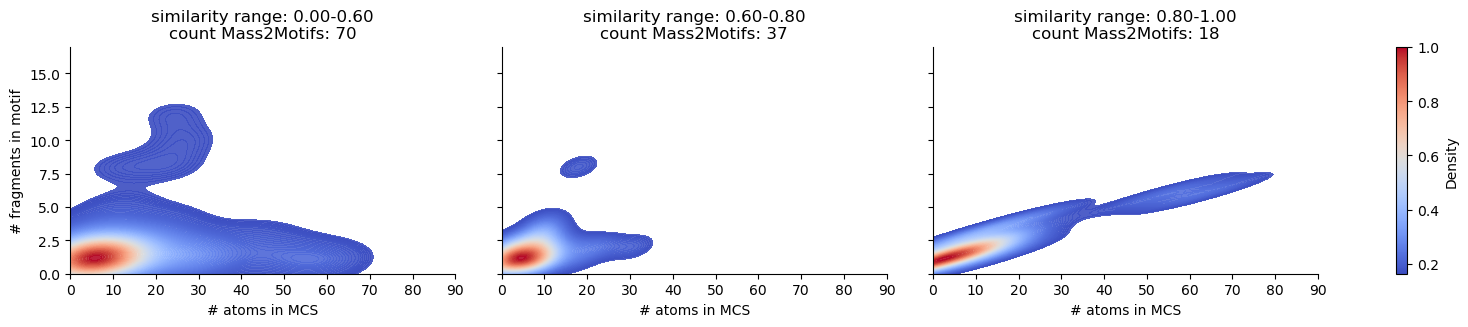

In [158]:
plot_inter_similarity_grid(results_1, bins=np.array([0,0.60,0.8,1.00001]), min_points_kde=2, name="supp_1.jpg")

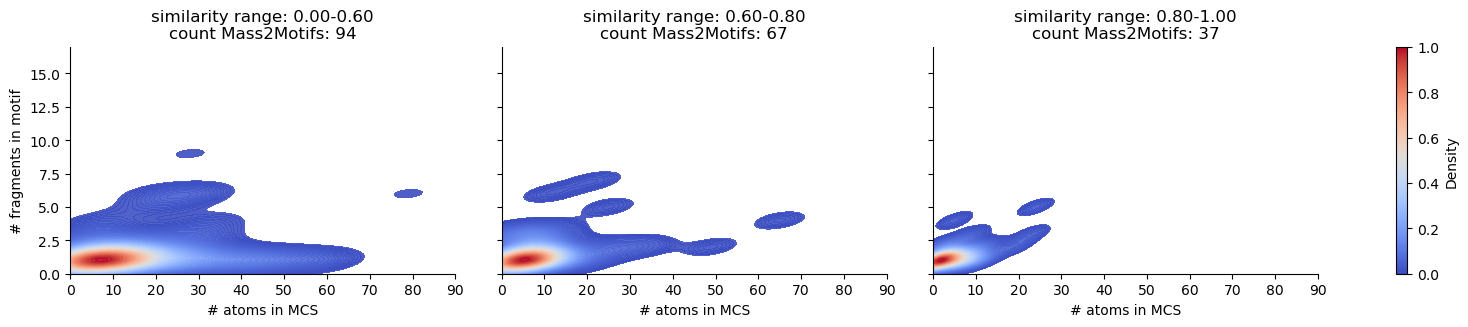

In [159]:
plot_inter_similarity_grid(results_2_4, bins=np.array([0,0.60,0.8,1.00001]), min_points_kde=2, name="supp_2.jpg")

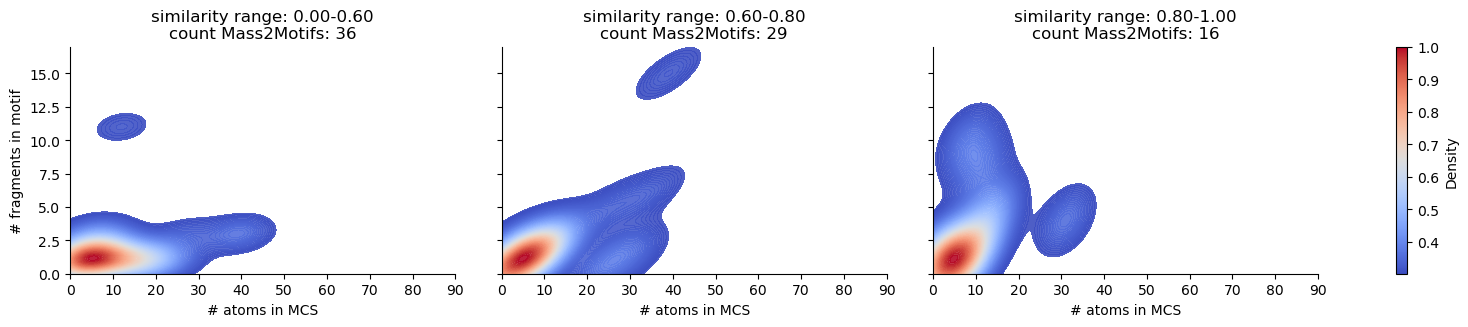

In [160]:
plot_inter_similarity_grid(results_5_7, bins=np.array([0,0.60,0.8,1.00001]), min_points_kde=2, name="supp_3.jpg")

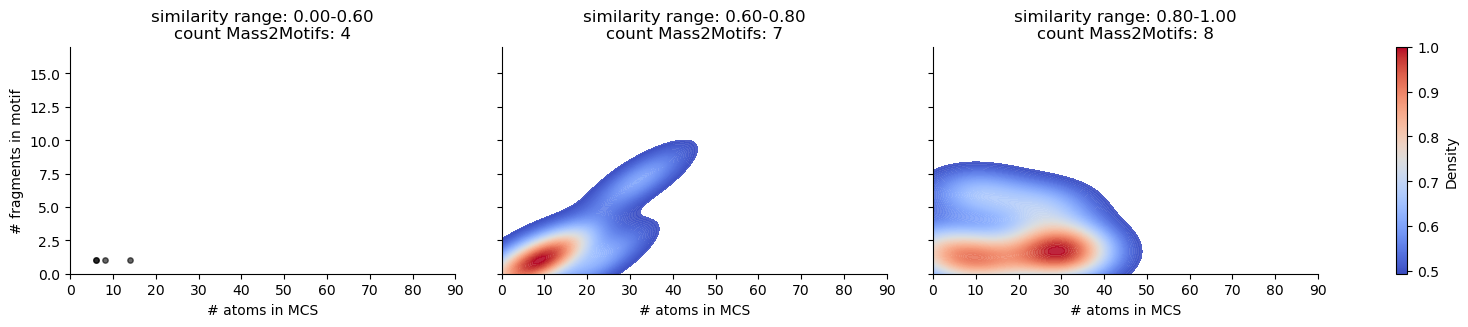

In [161]:
plot_inter_similarity_grid(results_8_10, bins=np.array([0,0.60,0.8,1.00001]), min_points_kde=2, name="supp_4.jpg")

---